# Unemployment assignment

+ The UnemploymentSpain.dat dataset contains the unemployment figures for Spain for every month between January 2001 and October 2022. The total unemployment is given.

In [2]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
import warnings
warnings.filterwarnings("ignore")

#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 

# Machine Learning libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf
from datetime import datetime,timedelta


# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

from sklearn import set_config
set_config(display='diagram')

# MLTOOLS - Custom library
from mltools import regression_tools as RT
from mltools import forecast_tools as FT
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns
import forecast_utils as fu

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

# Statsmodels time series 
#from statsmodels.tsa import SARIMAX
import statsmodels.api as sm

# Datetime for managing dates
from datetime import datetime
# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st
import scipy as sp

torch installation could not be found, only numpy activation functions allowed


---
## READ THE DATASET

In [4]:
# Import data
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
df = pd.read_csv('UnemploymentSpain.dat',sep="\t", parse_dates=['DATE'], date_parser=dateparse, index_col='DATE')
df.head(3)

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006

<AxesSubplot:title={'center':'Unemployment in Spain'}, xlabel='DATE'>

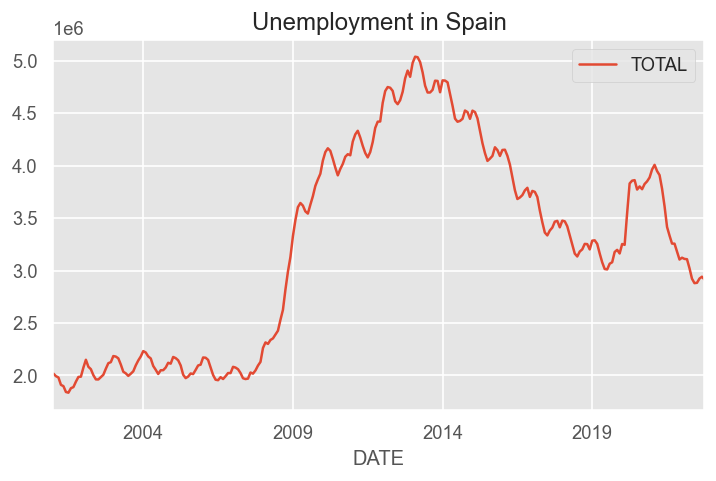

In [5]:
df.plot(title='Unemployment in Spain',figsize=(7,4))

In [6]:
df_ts = df[['TOTAL']] # Maintain data.frame format for column
df_ts.head(3)

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006

---
## Identification process

### 1. Plot the series and search for possible outliers

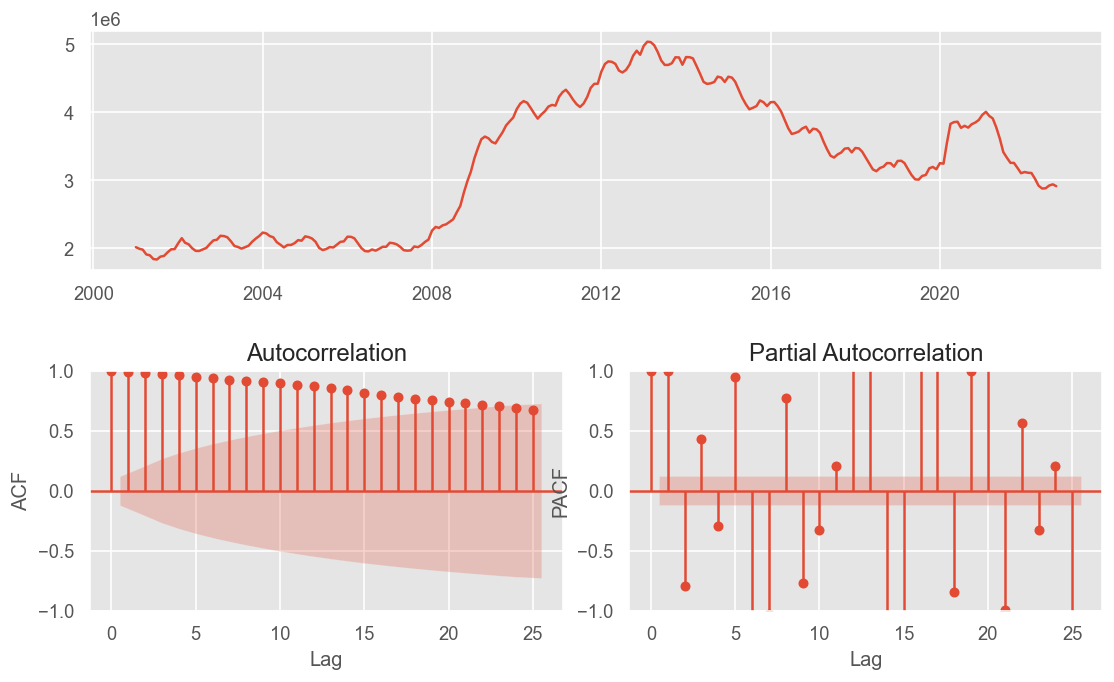

In [7]:
# ACF and PACF of the time series -> identify significant lags and order
plt.figure(figsize=[10,6])
FT.ts_display(df_ts)

+ In the own graph of the unemployment we can see that our time series is not mean stacionary because of the huge jump from 80 to 100 and increasing it. Regarding to the variance we can also see that is not stacionary, for example in the same step of the mean.

+ Another proof of the non stationary for the mean it is in the ACF graph. Here we view an slowly decreasing curve that implies that non stationary.

### 2. Stabilize the variance (if needed)

<Figure size 720x720 with 0 Axes>

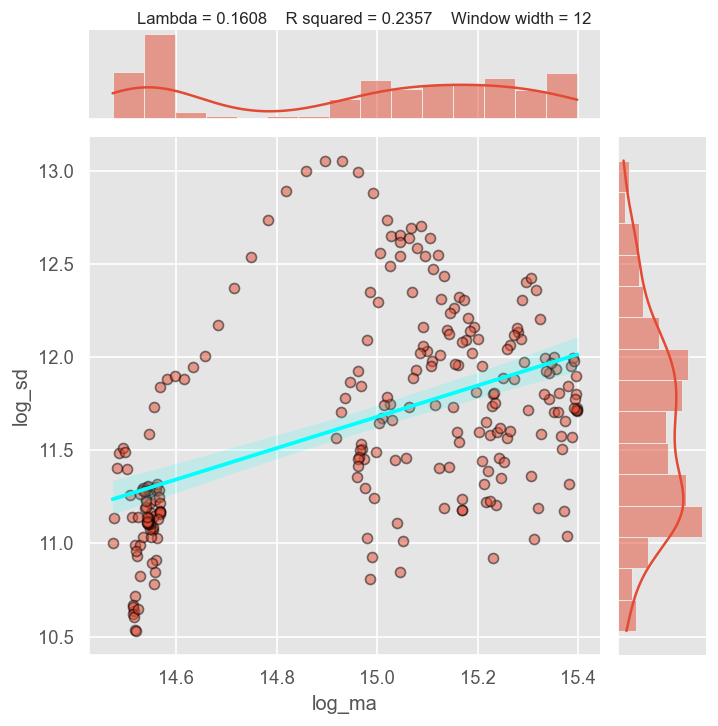

0.16079158556031659

In [8]:
# Box-cox transformation
plt.figure(figsize=[6,6])
FT.boxcox_lambda_plot(df_ts, window_width=12)



+ In the representation we have several proofs for conclude that the variance is not stationary. The first proof is the $\lambda$ which is clearly far from 1. The other one is the graph where the straight line shows that as the mean increase, the variance have the same behaviour.



initial lambda:  0.16079158556031659
lambda transformed to :  0.9862199131852231


<Figure size 960x960 with 0 Axes>

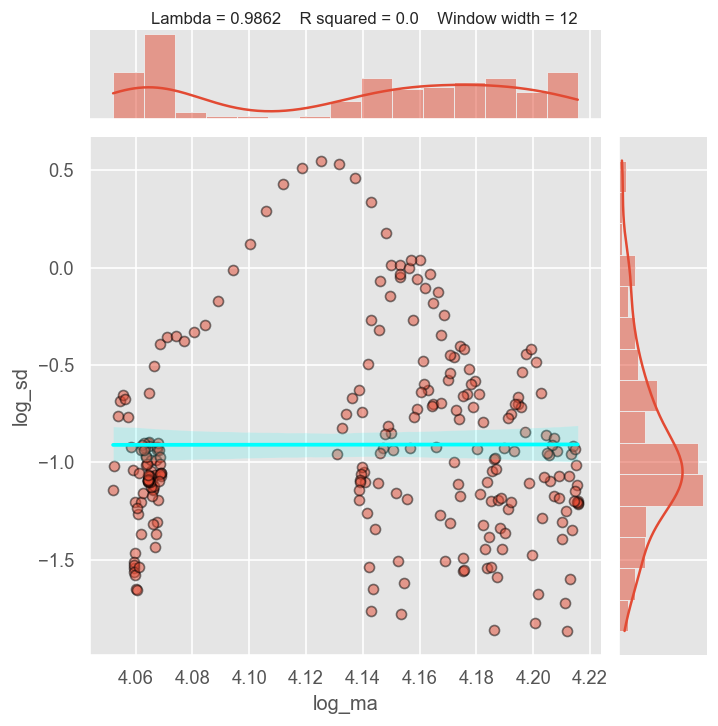

<Figure size 960x600 with 0 Axes>

In [9]:
z=fu.try_boxcox_transform(df_ts, window_width=12)

+ In the representation we have several proofs for conclude that the variance is not stationary. The first proof is the $\lambda$ which is clearly far from 1. The other one is the graph where the straight line shows that as the mean increase, the variance have the same behaviour.



+ Now the same parameters as before show us that the BOX_COX method has caused it to have a stationary variance. In this case, $\lambda$ is closer to $1$ and the straight line is parallel to the x-axis.

### 3. Analyze regular differencing

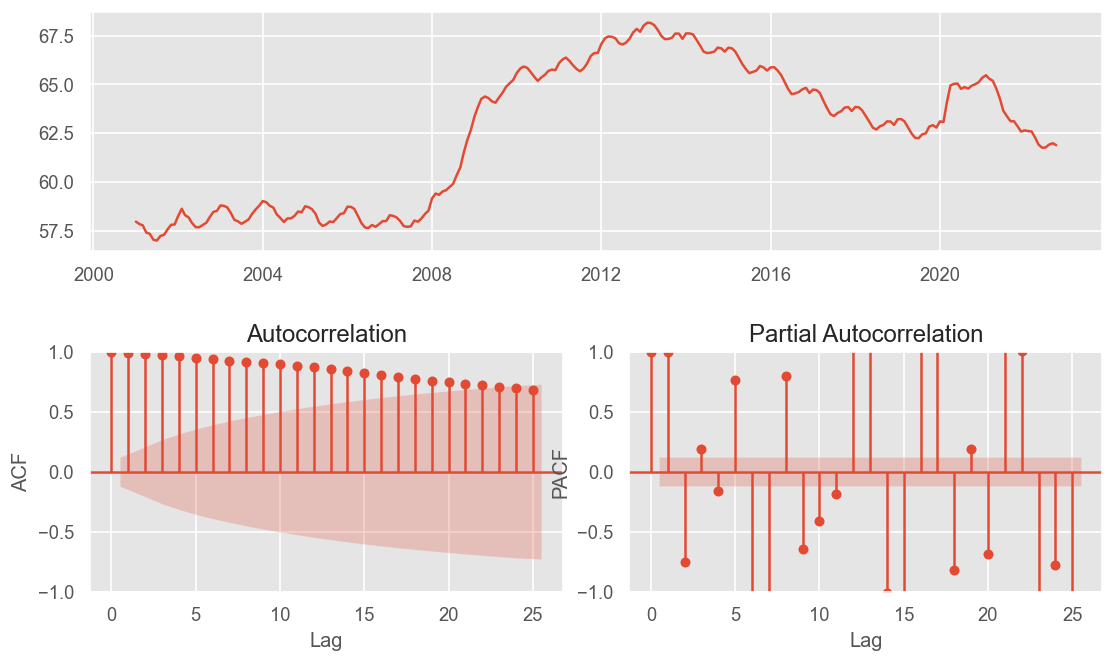

In [10]:
#Graphically
plt.figure(figsize=[10,6])
FT.ts_display(z)

In [11]:
fu.check_stationarity(z)

ADF Statistic: -1.644424
p-value: 0.459950
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
The series is not stationary


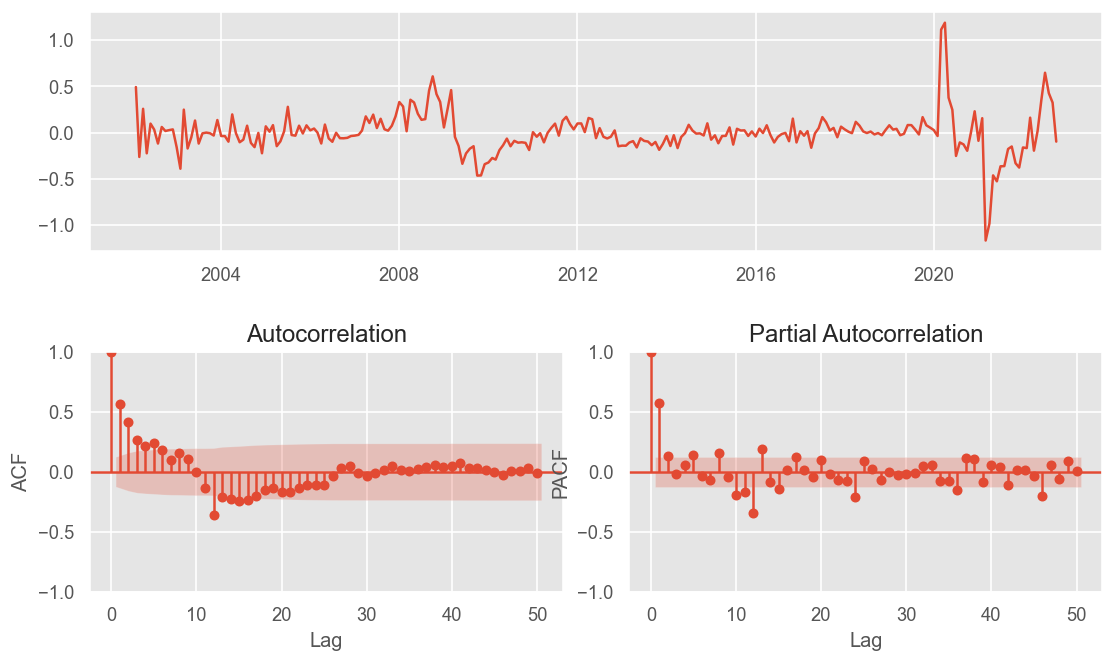

In [12]:
fu.plot_difference_z(z,d=1,D=1,S=12)

+ We choose as a first approximation for coefficients of ARIMA(1,1,0), that is, coefficient one for AR and 0 for moving average (MA). These coefficients have been taken because if we look at the PACF there is a single significant bar and in the ACF there are 2. By taking the least complex we obtain this model.

### 4. Fit ARIMA model and check significance of the coefficients

In [13]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,1,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())

/Volumes/Transcend/opt/anaconda3/envs/fmad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Volumes/Transcend/opt/anaconda3/envs/fmad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.12456D-01    |proj g|=  1.66076D+00

At iterate    5    f= -4.58927D-01    |proj g|=  1.07580D+00

At iterate   10    f= -4.90633D-01    |proj g|=  1.60703D-01

At iterate   15    f= -4.93086D-01    |proj g|=  8.92845D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     64      2     0     0   2.386D-04  -4.931D-01
  F = -0.49308612601828761     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 129.189
Date:                              Thu, 01 Dec 2022   AIC                           -252.377
Time:                                      15:56:25


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Volumes/Transcend/opt/anaconda3/envs/fmad/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Comprobacion de los mejores parametros

In [14]:
""" ord=[(1,1,0),(0,1,1),(2,1,0),(0,1,2),(1,1,2)]
season=[(0,1,1,12),(1,1,0,12),(0,1,1,13)]
t=['c','t','n','ct'] """
# al=fu.sarimafit(z,ord,season,t)
#al.head(3)

" ord=[(1,1,0),(0,1,1),(2,1,0),(0,1,2),(1,1,2)]\nseason=[(0,1,1,12),(1,1,0,12),(0,1,1,13)]\nt=['c','t','n','ct'] "

+ An ARIMA(1,1,1) model has also been tested, but the p-value of the MA coefficient is significantly high and therefore it has been discarded.

+ In this summary it can be seen that the p-value is significantly low. **Comment the coefficients (AIC,BIC and HQIC)**

### 5. Analyze residuals

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  19.552424   0.769892


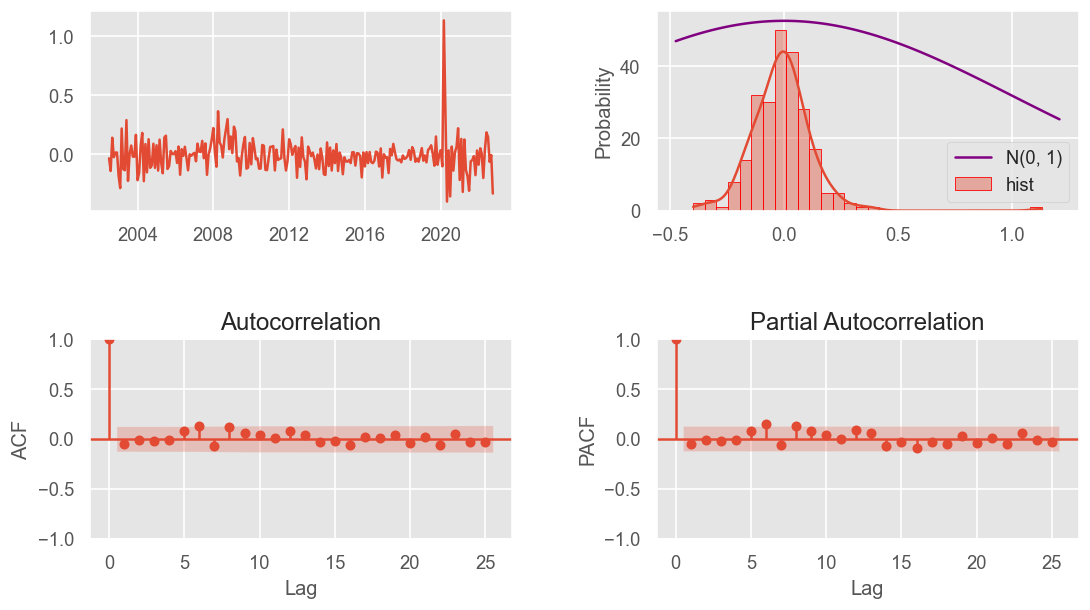

In [15]:
# Plot residual error
plt.figure(figsize=[10,6])
FT.check_residuals(pd.DataFrame(sarima_fit.resid.iloc[18:]))

+ In this analysis, the residuals have to be white noise. In ACF and PACF it can be said that it is white noise, it is true that there are a couple of bars on the limit but it can generally be considered white noise.

### 6. Forecast SIN EXOGEN

<Figure size 1200x480 with 0 Axes>

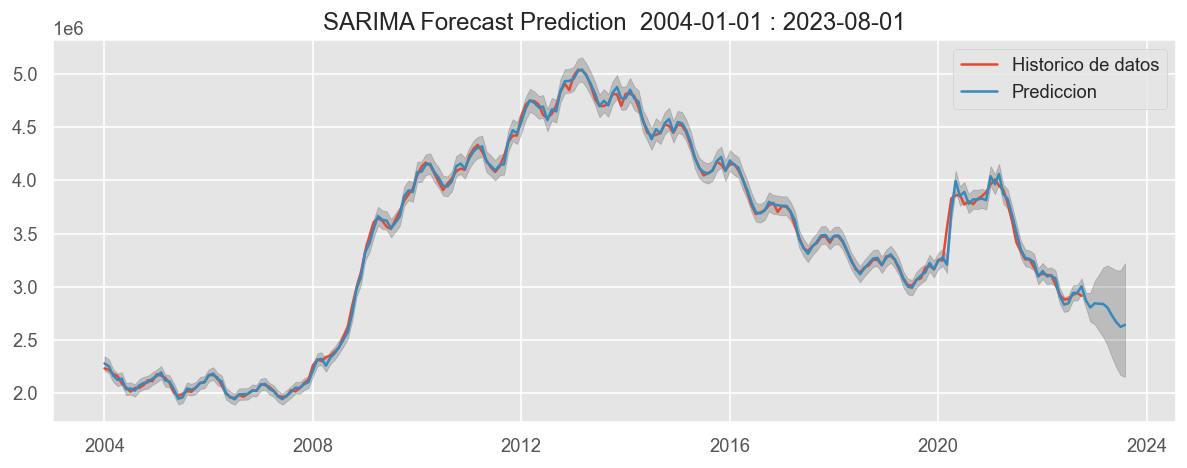

In [16]:
fu.plot_prediction_model(df_ts,model_=sarima_fit,start='2004-01-01',horizon=10,horizon_type='months',forecast=False,figsize=(10,4))

<Figure size 1200x360 with 0 Axes>

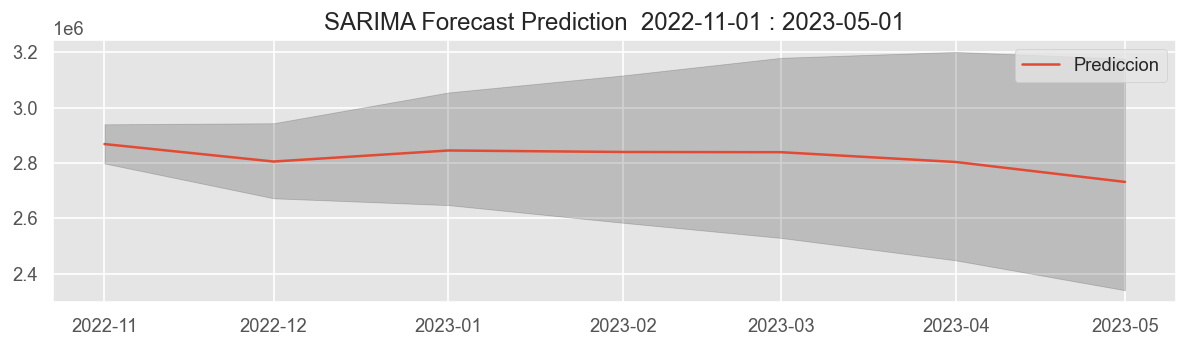

In [17]:
fu.plot_prediction_model(df_ts,model_=sarima_fit,start='2004-01-01',horizon=7,horizon_type='months',forecast=True,figsize=(10,3))

# SARIMAX NO EXOGEN NOVEMBER PREDICTION

In [18]:
fu.predict_sarimax_single_date("2022-11",df_ts,sarima_fit)

Make Sure that you use the correct BOX_COX boolean value according to the previous model

Model has no exogenous variables
------------------------------------------------------------------------
Mean predicted for 2022-11 :  2868535.273345963
Conf int predicted for 2022-11 :  [2798518.23762584 2940016.54043306]


## 7. Forecast Con EXOGEN

Se genera la variable exogena de covid y de algunos outliers raros que consideramos según las funciópn check_outliers ed los residuos

In [19]:
exogen_vars=z.copy()
exogen_vars["COVID"]=np.nan
exogen_vars.COVID.loc["2019-04":"2020-02"]=1
exogen_vars.fillna(0,inplace=True)
outliers=fu.check_outliers(sarima_fit.resid)
outliers=outliers.sort_index()
outliers=outliers.iloc[0:4]
exogen_vars["OUTLIERS"]=np.nan
exogen_vars.OUTLIERS.loc[outliers.index]=1
exogen_vars.fillna(0,inplace=True)
exogen_vars.OUTLIERS.value_counts()
outliers=fu.check_outliers(sarima_fit.resid)
outliers_=outliers.sort_index()
outliers=outliers_.iloc[9:10]
exogen_vars["OUTLIERS2"]=np.nan
exogen_vars.OUTLIERS2.loc[outliers.index]=1
exogen_vars.fillna(0,inplace=True)
exogen_vars.OUTLIERS2.value_counts()

0.0    261
1.0      1
Name: OUTLIERS2, dtype: int64

In [20]:
# Fit model with estimated order
sarimaEXOGEN = SARIMAX(z, 
                    order=(1,1,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False,
                    exog=exogen_vars.iloc[:,1:]).fit()

print(sarimaEXOGEN.summary())

/Volumes/Transcend/opt/anaconda3/envs/fmad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Volumes/Transcend/opt/anaconda3/envs/fmad/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48331D-01    |proj g|=  2.56960D-01

At iterate    5    f= -4.84430D-01    |proj g|=  1.18186D+00

At iterate   10    f= -5.56839D-01    |proj g|=  1.54413D-01

At iterate   15    f= -5.58453D-01    |proj g|=  1.59618D-02

At iterate   20    f= -5.58679D-01    |proj g|=  5.48271D-02

At iterate   25    f= -5.58787D-01    |proj g|=  6.36977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     37      1     0     0   

<Figure size 1200x480 with 0 Axes>

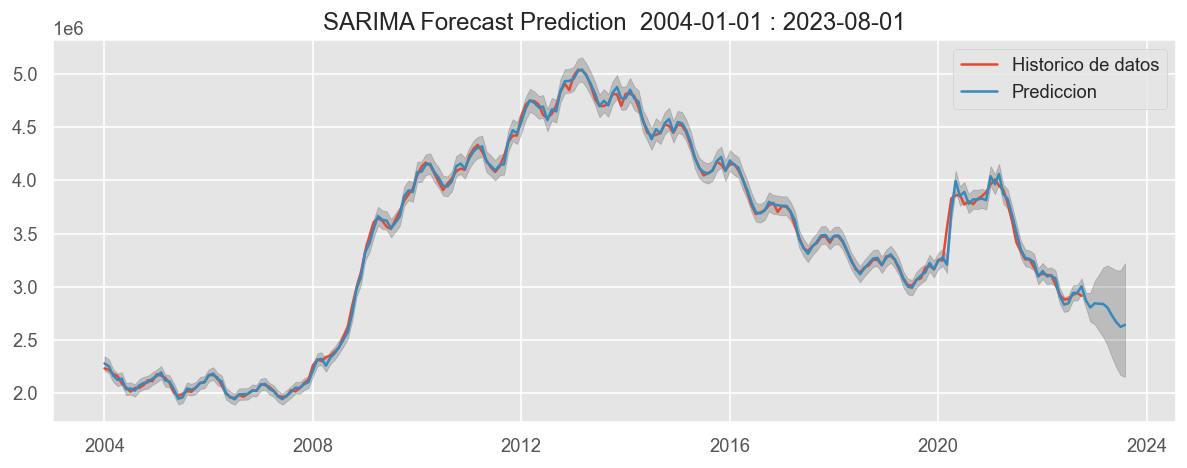

In [21]:
fu.plot_prediction_model(df_ts,model_=sarima_fit,start='2004-01-01',horizon=10,horizon_type='months',forecast=False,figsize=(10,4))

<Figure size 1200x360 with 0 Axes>

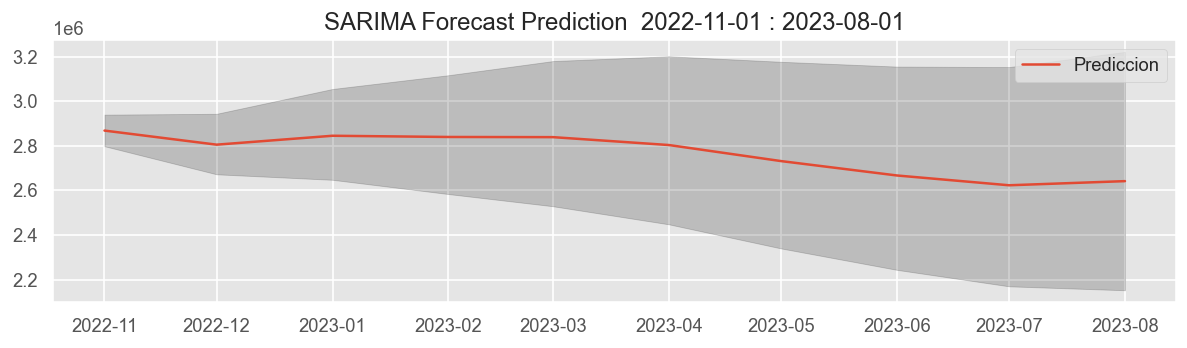

In [22]:
fu.plot_prediction_model(df_ts,model_=sarima_fit,start='2004-01-01',horizon=10,horizon_type='months',forecast=True,figsize=(10,3))

In [23]:
fu.predict_sarimax_single_date("2022-11",df_ts,sarimaEXOGEN)

Make Sure that you use the correct BOX_COX boolean value according to the previous model

The horizon of the prediction must be the same as the horizon of the exogenous variables
For future predictions exogeneous variables are assumed to be 0
--------------------------------------------------------------------------
Mean predicted for 2022-11 :  2863395.4886155264
Conf int predicted for 2022-11 :  [2798051.34964107 2930015.48854608]


## Comparación Scores de los SARIMAX

In [24]:
compare_sarima=fu.scores_sarimax(df_ts,[sarima_fit,sarimaEXOGEN],'2003-01',glob=globals(),scale=1,add_single_date_prediction="2022-11")

In [25]:
compare_sarima

RMSE           MSE           MAE        R2         AIC  \
sarimaEXOGEN  39406.959868  1.552908e+09  27079.562636  0.998262 -280.804424   
sarima_fit    42032.226735  1.766708e+09  28101.680614  0.998023 -252.377130   

              lower_yhat2022-11   yhat2022-11  upper_yhat2022-11  
sarimaEXOGEN       2.798051e+06  2.863395e+06       2.930015e+06  
sarima_fit         2.798518e+06  2.868535e+06       2.940017e+06

## NON-LINEAR MODEL

## Analysis over different lags, splits data and other parameters

Tarda como 15 mins

The following plot shows the performance of several MLP models over different lags, in this case given by a range of [1,15,1] and also by a spread of splits. The performance is measured by the RMSE scored of the model and the mean and standard deviation of the model for a given split of the relative percent difference bewtween TRAIN and TEST - (RMSE_TRAIN-RMSE_TEST)*100/RMSE_TRAIN) -. This allows us to select the model that fits our goals depending on the criteria. 

- We can see that while the split percent increases, the  RMSE Train does too and the RMSE Test strongly descreases. That is due to the COVID times.
- Beause we want a model that generalize, and doesnt overfit or underfit while obtaning a good  RMSE Test , we will set the split parameter around 0.95 due to his centered mean and a narrow standard deviation rather than the other that shows a worse generalization performance.
- All the models are train using the next hiperparemeter :
    - hidden_layers=[(4,2),(2,2),(3,3),(6,3),(15,),(9,),(8,),(6),(5,),(3,)]
    - alpha=[0.0001,0.001,0.01,0.1]

In [26]:
compare_MLPS=fu.split_performance_MLP(df_ts,[1,15,1],[0.7,0.75,0.8,0.85,0.9,0.92,0.93,0.94,0.95,0.98,0.99],hidden_layers=[(4,2),(2,2),(3,3),(6,3),(15,),(9,),(8,),(6),(5,),(3,)])

/Volumes/Transcend/opt/anaconda3/envs/fmad/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Volumes/Transcend/opt/anaconda3/envs/fmad/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Volumes/Transcend/opt/anaconda3/envs/fmad/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.

KeyboardInterrupt: 

Hence, we will select the 0.93 split with best RMSE_TEST followed by the best generalization. 

In [27]:
compare_MLPS[compare_MLPS["SPLIT train/test"]==0.93].sort_values(by=['RMSE_TEST'])

NameError: name 'compare_MLPS' is not defined

In [ ]:
compare_MLPS[compare_MLPS["SPLIT train/test"]==0.93].sort_values(by=['RMSE_TEST']).loc["MLP [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","BEST_PARAMS"]

{'MLP__alpha': 0.01, 'MLP__hidden_layer_sizes': (3,)}

# Select the model MLP [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] for analysis

## Analysis of the best model from scratch

In [ ]:
# Import data
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
df = pd.read_csv('UnemploymentSpain.dat',sep="\t", parse_dates=['DATE'], date_parser=dateparse, index_col='DATE')
dfT2=df.copy()
for lag in range(1,15):
    dfT2[f"lag{lag}"]=dfT2.TOTAL.shift(lag)

dfT2.dropna(inplace=True)

In [28]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
df = pd.read_csv('UnemploymentSpain.dat',sep="\t", parse_dates=['DATE'], date_parser=dateparse, index_col='DATE')
dfT2=df.copy()
dfT2['lag1'] = dfT2['TOTAL'].shift()
dfT2['lag2'] = dfT2['TOTAL'].shift(2)
dfT2['lag14'] = dfT2['TOTAL'].shift(14)
dfT2['lag12'] = dfT2['TOTAL'].shift(12)
dfT2['lag13'] = dfT2['TOTAL'].shift(13)
dfT2.dropna(inplace=True)

In [29]:
MLP_lagged_fit,X_train,X_test,y_train,y_test=fu.MLP_fit(dfT2,split=0.93,hidden_layers=[(3,)],alpha=[0.01],only_model=True)

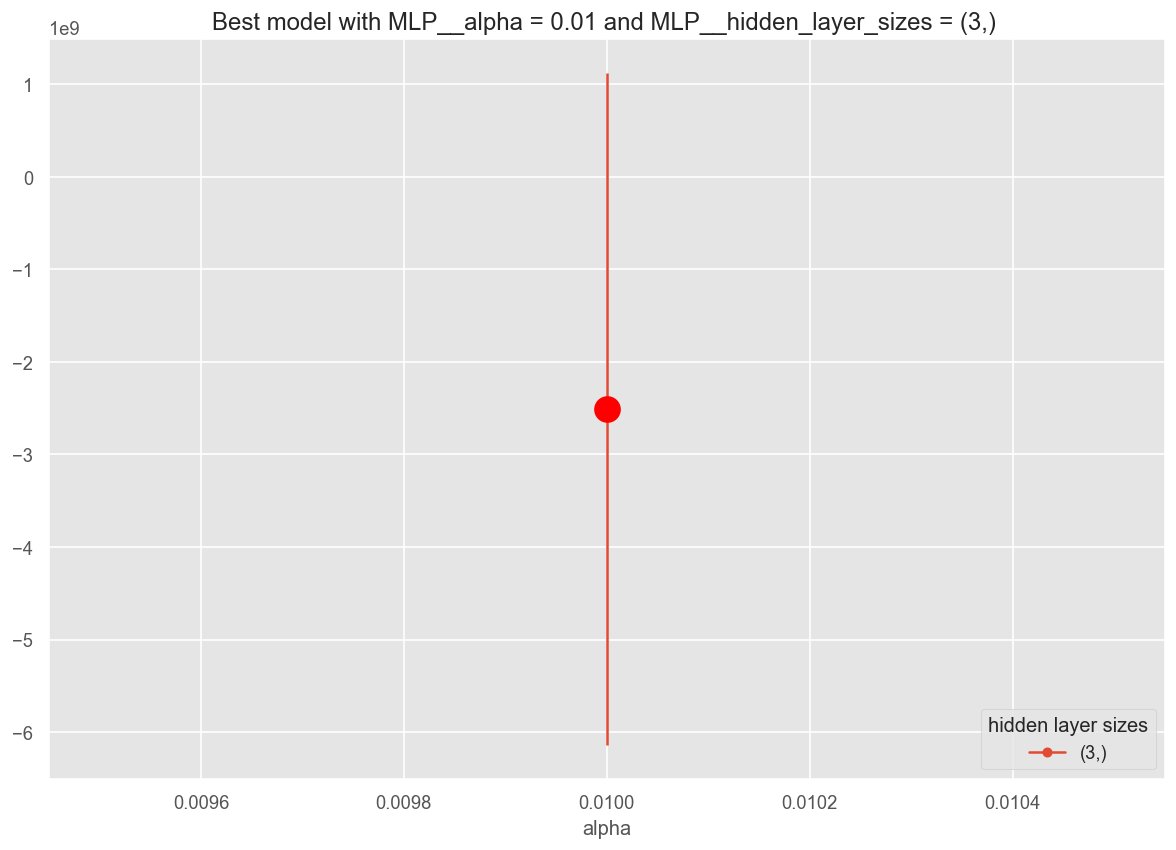

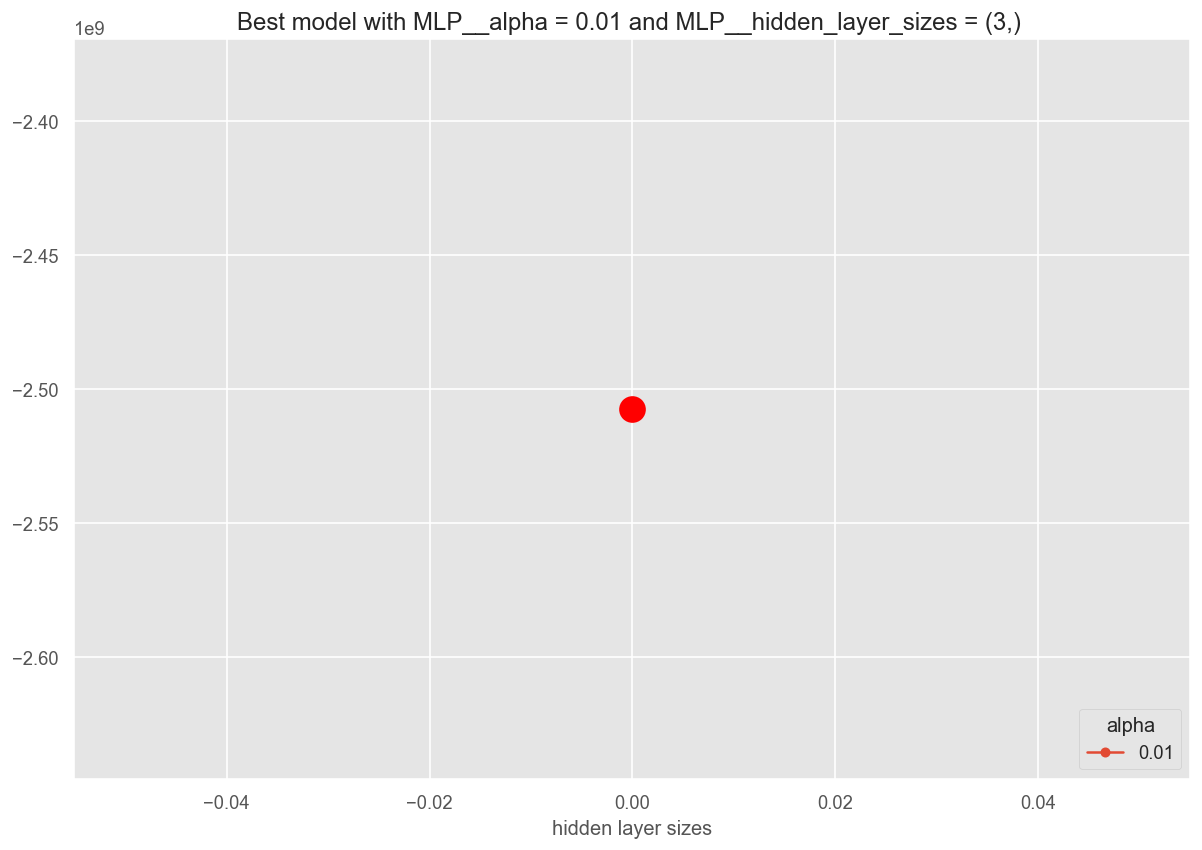

In [30]:
MT.plotModelGridError(MLP_lagged_fit)

In [31]:
mlp = MLP_lagged_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_lagged_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_] #dependindo de las capas se modifcrá las activaciones
X = MLP_lagged_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = X_train.columns.values.tolist()
X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=['TOTAL'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [32]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)

In [33]:
sensmlp.summary()

Sensitivity analysis of [5, 3, 1] MLP network.

Sensitivity measures of each output:

$TOTAL 

               mean         std  mean_squared
lag1   1.558335e+06  112.001648  1.558335e+06
lag2  -5.723952e+05   27.595064  5.723952e+05
lag14  3.973239e+05   33.653275  3.973239e+05
lag12  6.737972e+05    9.804901  6.737972e+05
lag13 -1.067938e+06    8.134246  1.067938e+06


In [34]:
sensmlp.info()

Sensitivity analysis of [5, 3, 1] MLP network.

231 samples

Sensitivities of each output (only 5 first samples):

$TOTAL 

           lag1           lag2          lag14          lag12         lag13
0  1.558375e+06 -572385.123653  397336.189666  673800.774203 -1.067941e+06
1  1.558375e+06 -572385.123653  397336.189666  673800.774203 -1.067941e+06
2  1.558375e+06 -572385.123653  397336.189666  673800.774203 -1.067941e+06
3  1.558027e+06 -572471.014408  397231.442483  673770.256052 -1.067916e+06
4  1.558027e+06 -572471.014408  397231.442483  673770.256052 -1.067916e+06


## Aquí da error en dibujar la última gráfica y no se porqué, pero el modelo es correcto

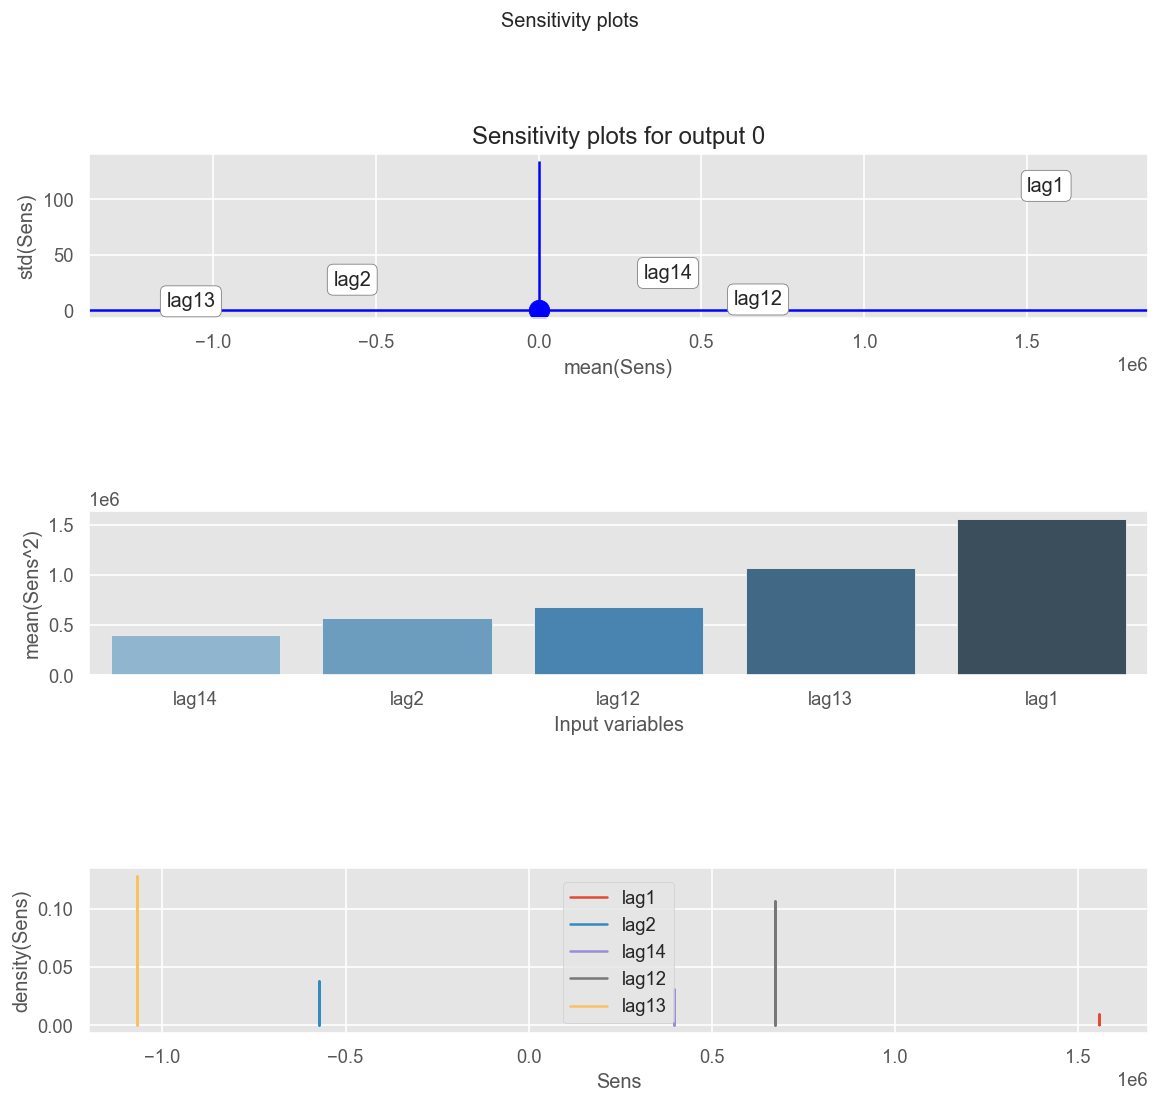

In [35]:
#plt.figure(figsize=(10,15))
sensmlp.plot()
plt.tight_layout()
plt.gca().figure.set_size_inches(10, 10)

In [36]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['TOTAL'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['TOTAL'] = y_test # We will call Y as output variable for simplicity
## Obtain a report of the model based on predictions ------------------------
dfTR_eval['MLP_lagged_pred'] = MLP_lagged_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_lagged_pred'] = MLP_lagged_fit.predict(X_test) 

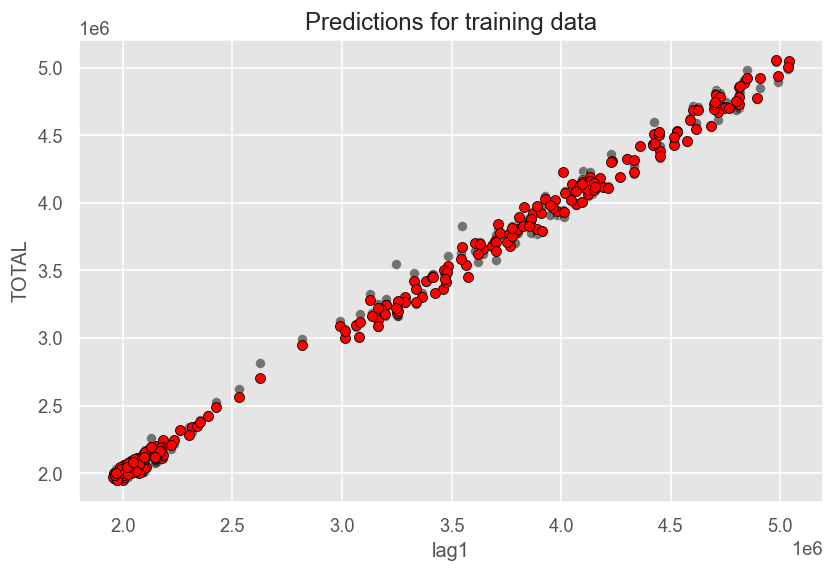

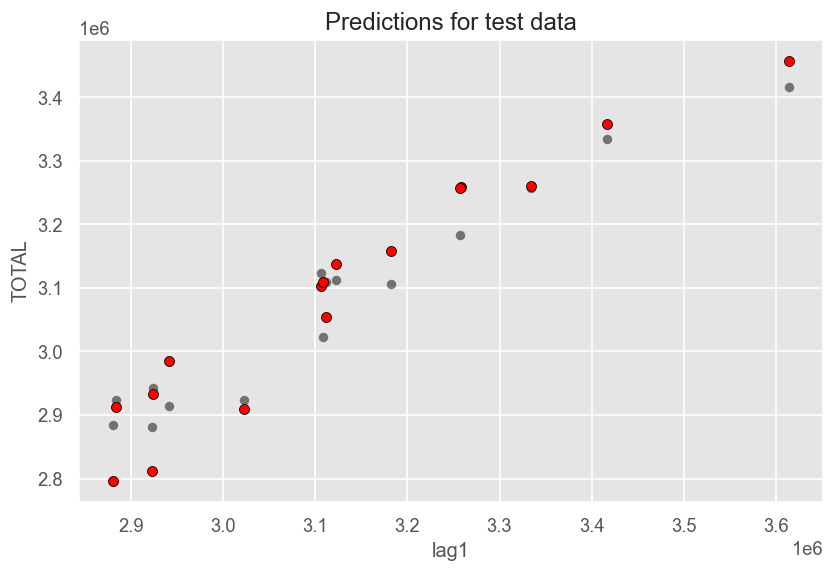

In [37]:
### Plot predictions of the model
sns.scatterplot(x='lag1', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5, legend=True)
sns.scatterplot(x='lag1', y='MLP_lagged_pred', data=dfTR_eval, color='red', edgecolor='black',legend=True).set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='lag1', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5,legend=True)
sns.scatterplot(x='lag1', y='MLP_lagged_pred', data=dfTS_eval, color='red', edgecolor='black',legend=True).set_title('Predictions for test data')
plt.show()

In [38]:
#Training and test errors
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred']))
#Training and test errors
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred']))

Training MAE: 28851.97898462178
Test MAE: 40268.65531943354
Training RMSE: 45621.918283201594
Test RMSE: 49798.79559204936
Training R2: 0.9978938980049025
Test R2: 0.9080806312769827


In [39]:
#Training and test errors
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred']))
#Training and test errors
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred']))

Training MAE: 28851.97898462178
Test MAE: 40268.65531943354
Training RMSE: 45621.918283201594
Test RMSE: 49798.79559204936
Training R2: 0.9978938980049025
Test R2: 0.9080806312769827


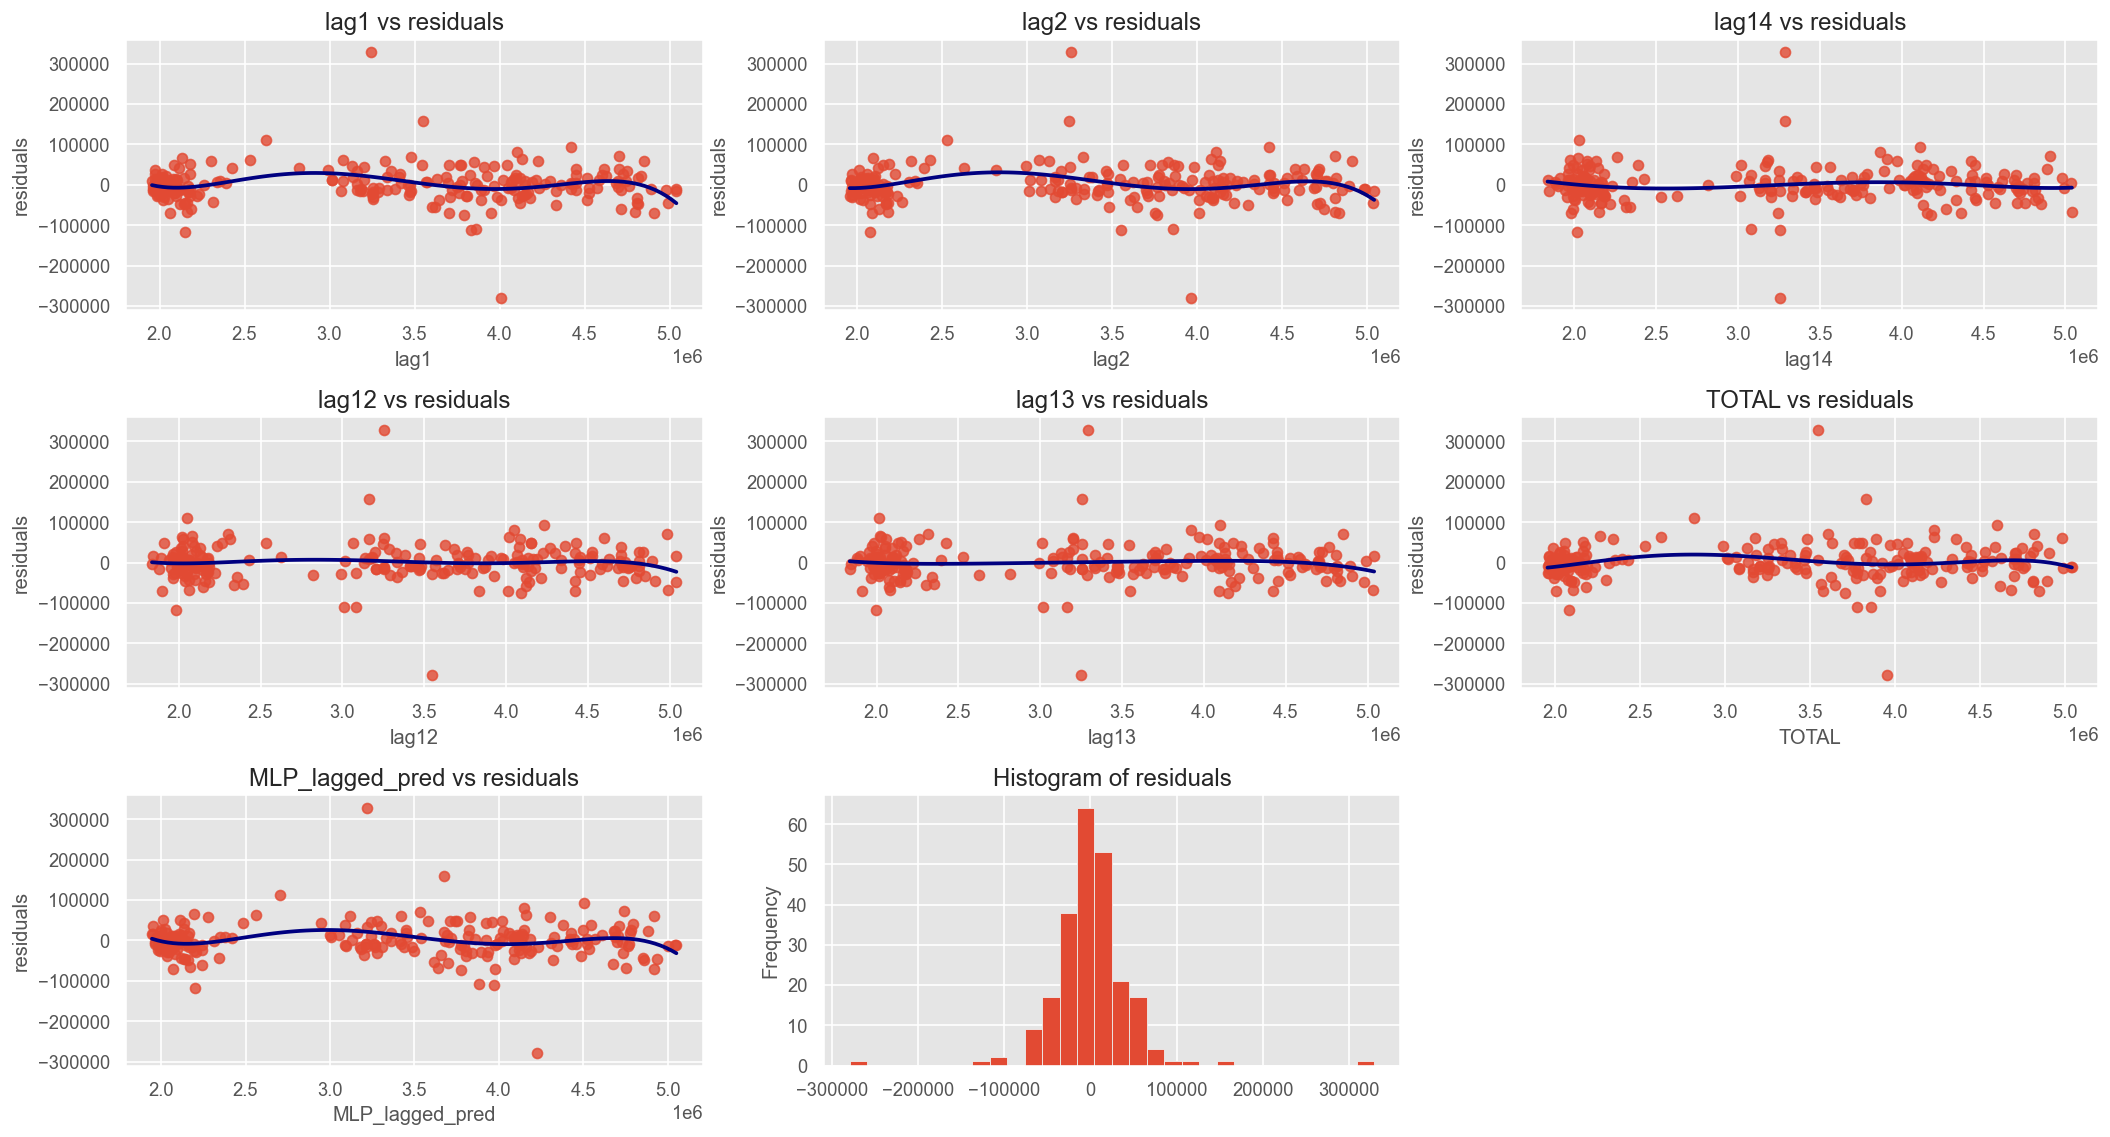

In [40]:
RT.plotModelDiagnosis(dfTR_eval, 'MLP_lagged_pred', 'TOTAL',figsize=(18,10))

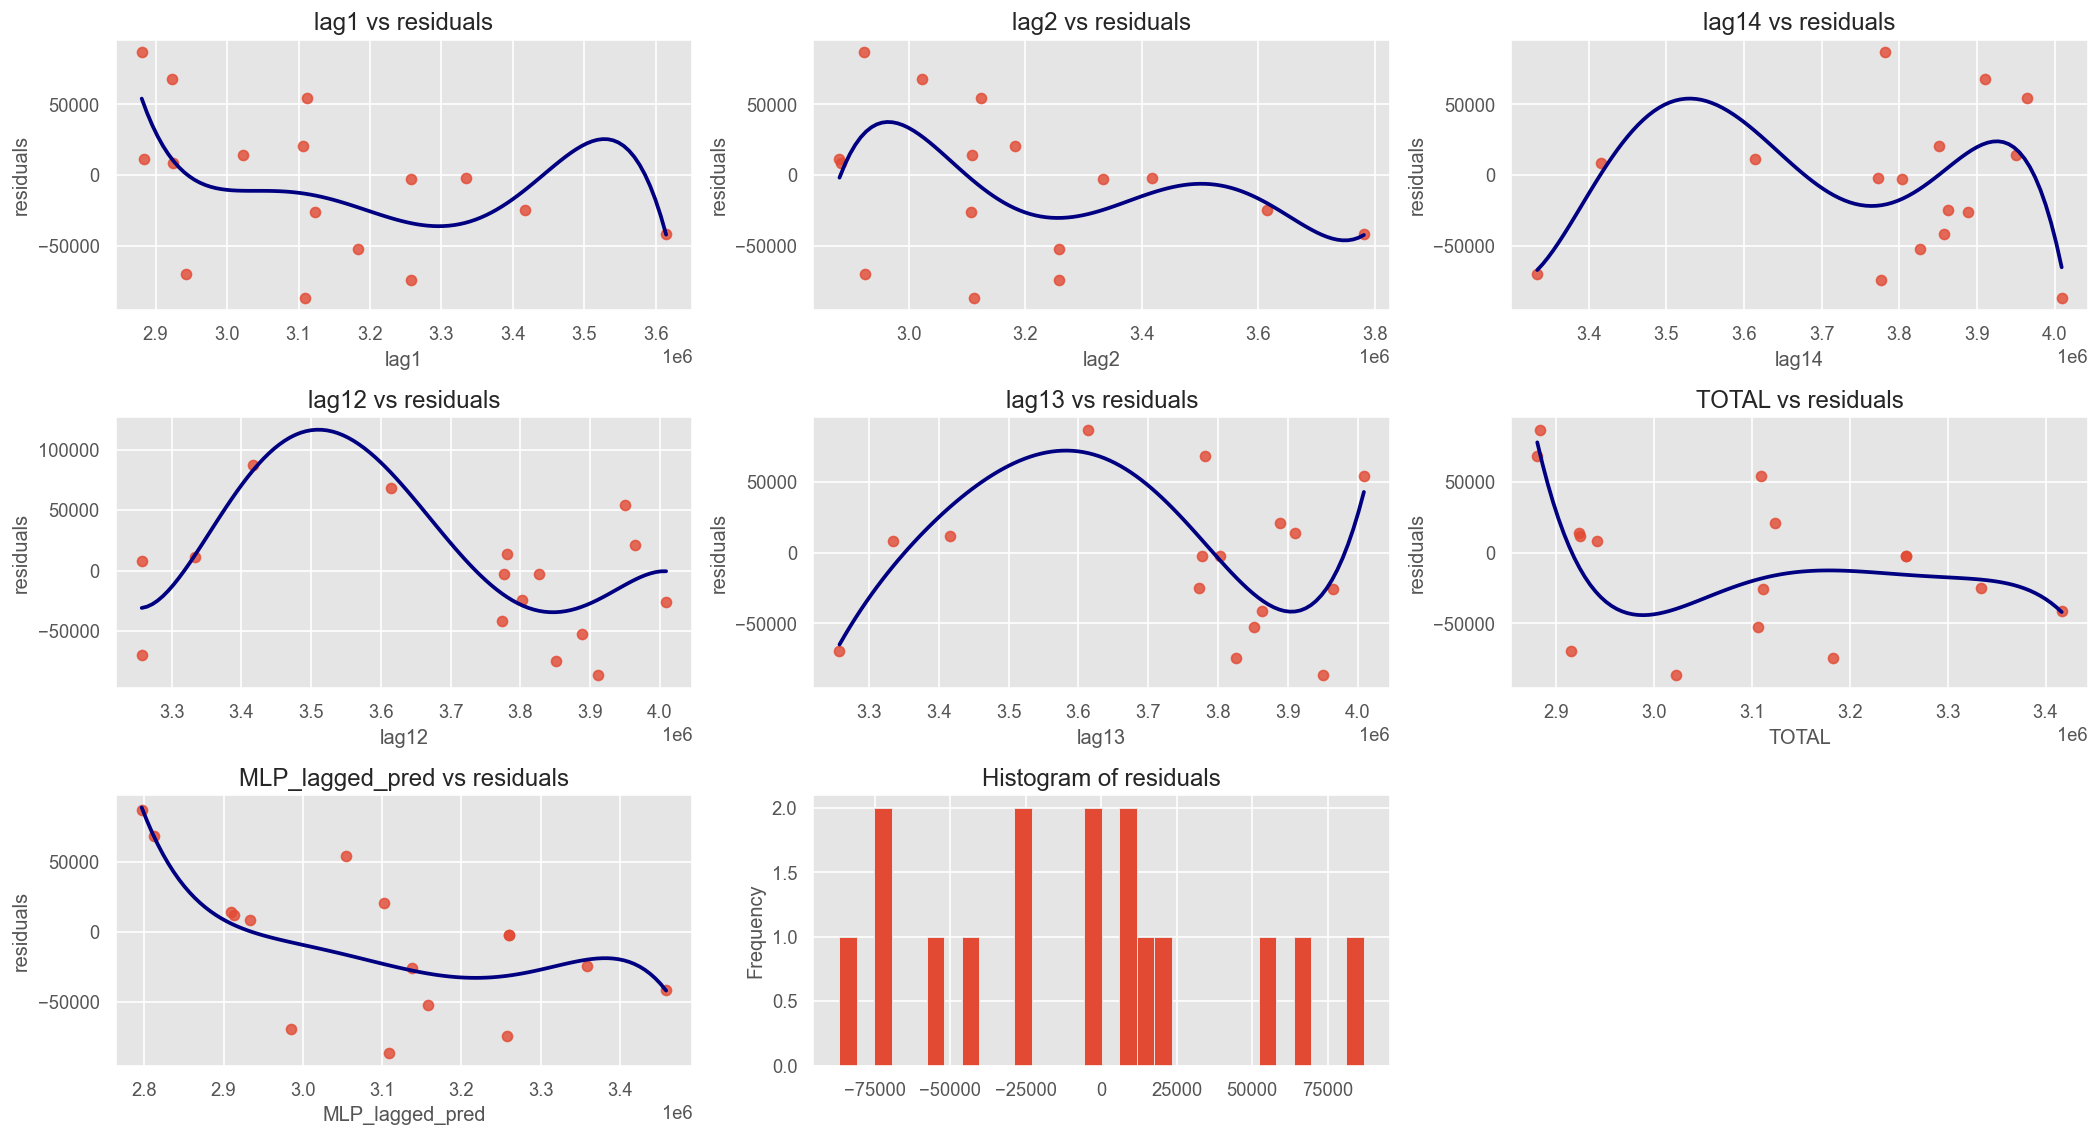

In [41]:
#make the subplots bigger
RT.plotModelDiagnosis(dfTS_eval, 'MLP_lagged_pred', 'TOTAL',figsize=(18,10))

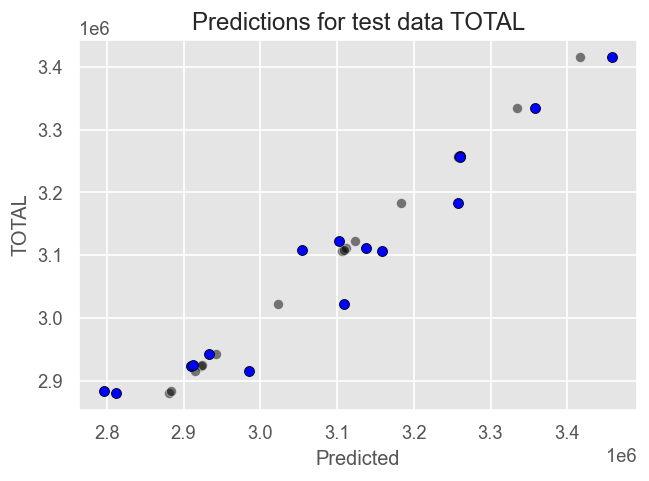

In [42]:
# Visualize prediction with respect to temperature
plt.figure(figsize=(6,4))
sns.scatterplot(data=dfTS_eval, x='TOTAL', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='MLP_lagged_pred', y='TOTAL', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.title('Predictions for test data TOTAL')
plt.show()

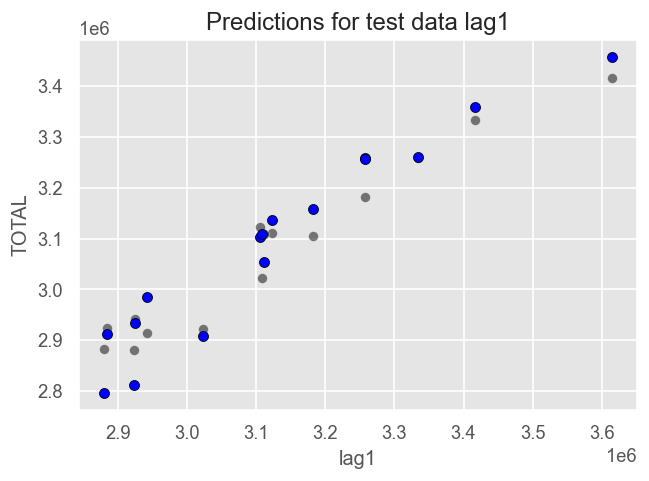

In [43]:
# Visualize prediction with respect to TOTAL_lag1erature
plt.figure(figsize=(6,4))
sns.scatterplot(data=dfTS_eval, x='lag1', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='lag1', y='MLP_lagged_pred', color='blue', edgecolor='black')
plt.title('Predictions for test data lag1')
plt.show()

<Figure size 1200x720 with 0 Axes>

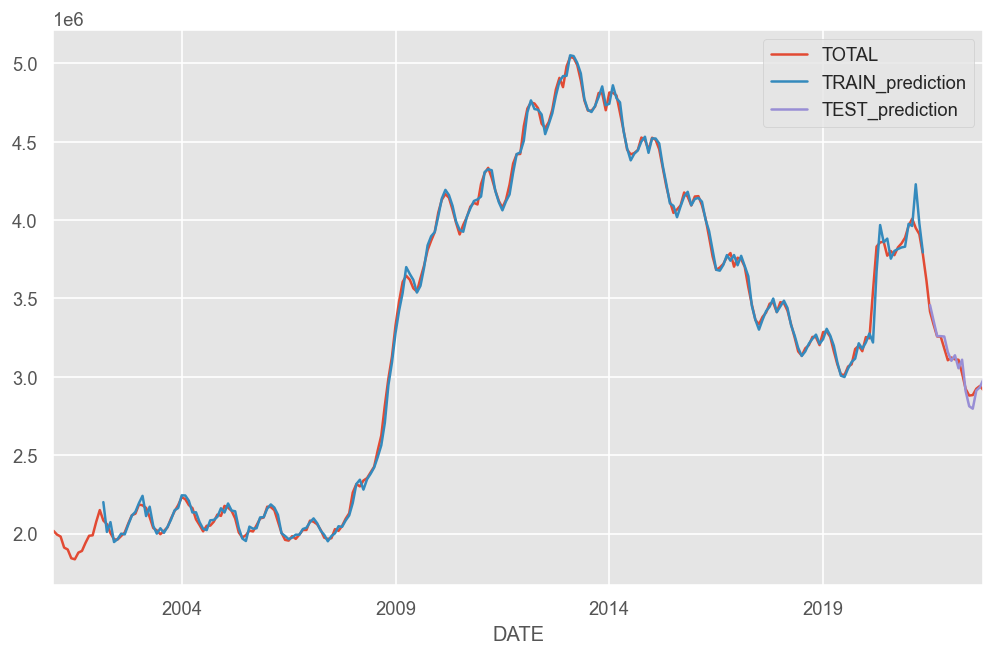

In [44]:
plt.figure(figsize=(10,6))
df.plot(figsize=(10,6))
dfTR_eval['MLP_lagged_pred'].plot(label='TRAIN_prediction')
dfTS_eval['MLP_lagged_pred'].plot(label="TEST_prediction")
plt.legend()

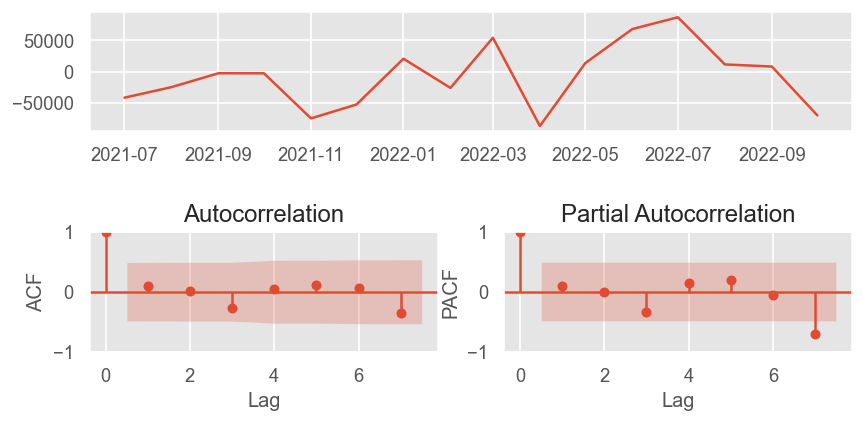

In [45]:
plt.figure(figsize=(8,4))
FT.ts_display(dfTS_eval['TOTAL'] - dfTS_eval['MLP_lagged_pred'],lags=7)


# November 2022 MLP prediction

- For the selected MLP model: MLP [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

In [46]:
print("La predicción para el mes siguiente: ")
#MLP_lagged_fit.predict(fu.values_for_next_prediction(df,list(range(1,15)),dfT2.columns[1:]))
MLP_lagged_fit.predict(fu.values_for_next_prediction(df,[1,2,12,13,14],dfT2.columns[1:]))
#MLP_lagged_fit.predict(fu.values_for_next_prediction(df,list([1,13,14,2,12]),dfT2.columns[1:]))

La predicción para el mes siguiente: 


array([2874236.63043619])

In [47]:
compare_models=compare_sarima.copy()
compare_models
compare_mlp=pd.DataFrame(columns=compare_models.columns,index=["MLP_lag[1:14]"])
compare_mlp.iloc[0,0]="TRAIN: "+str(round(math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred'])),1))+" "+"TEST: "+str(round(math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred'])),1))
compare_mlp.iloc[0,3]="TRAIN: "+str(round(r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred']),3))+" "+"TEST: "+str(round(r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred']),3))
compare_mlp.iloc[0,2]="TRAIN: "+str(round(mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred']),1))+" "+"TEST: "+str(round(mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred']),1))
compare_mlp.iloc[0,1]="TRAIN: "+str(round(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_lagged_pred']),1))+" "+"TEST: "+str(round(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_lagged_pred']),1))
compare_mlp.iloc[0,6]=round(MLP_lagged_fit.predict(fu.values_for_next_prediction(df,list(range(1,15)),dfT2.columns[1:]))[0],1)

ValueError: Shape of passed values is (1, 14), indices imply (1, 5)

In [ ]:
compare_models=pd.concat([compare_models,compare_mlp])

# Prophet Model

In [48]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
df=pd.read_csv('UnemploymentSpain.dat', sep = '\t', parse_dates=['DATE'], date_parser=dateparse)
df = df.rename(columns={'DATE': 'ds',
                        'TOTAL': 'y'})
df.head()

ds        y
0 2001-01-01  2017389
1 2001-02-01  1993273
2 2001-03-01  1981006
3 2001-04-01  1910453
4 2001-05-01  1898285

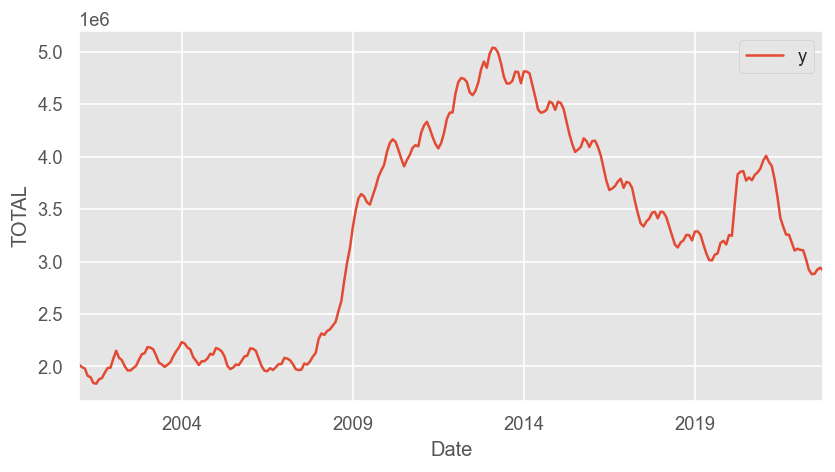

In [49]:
ax = df.set_index('ds').plot(figsize=(8, 4))
ax.set_ylabel('TOTAL')
ax.set_xlabel('Date')

plt.show()

In [50]:
prophet_fit = Prophet()
prophet_fit.fit(df)

16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
# Create new dates with monthly ('MS') frequency. Take this into account when using data with a different frequency.
# In this case, we want 2 new years of samples
n_years = 1
future_dates = prophet_fit.make_future_dataframe(periods=n_years*12, freq='MS')
future_dates.tail()

ds
269 2023-06-01
270 2023-07-01
271 2023-08-01
272 2023-09-01
273 2023-10-01

In [52]:
future = prophet_fit.predict(future_dates)
future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
269 2023-06-01  3.123237e+06  2.860428e+06  3.386698e+06
270 2023-07-01  3.096735e+06  2.822350e+06  3.359175e+06
271 2023-08-01  3.126406e+06  2.869284e+06  3.388229e+06
272 2023-09-01  3.147781e+06  2.863343e+06  3.420208e+06
273 2023-10-01  3.200956e+06  2.918735e+06  3.458013e+06

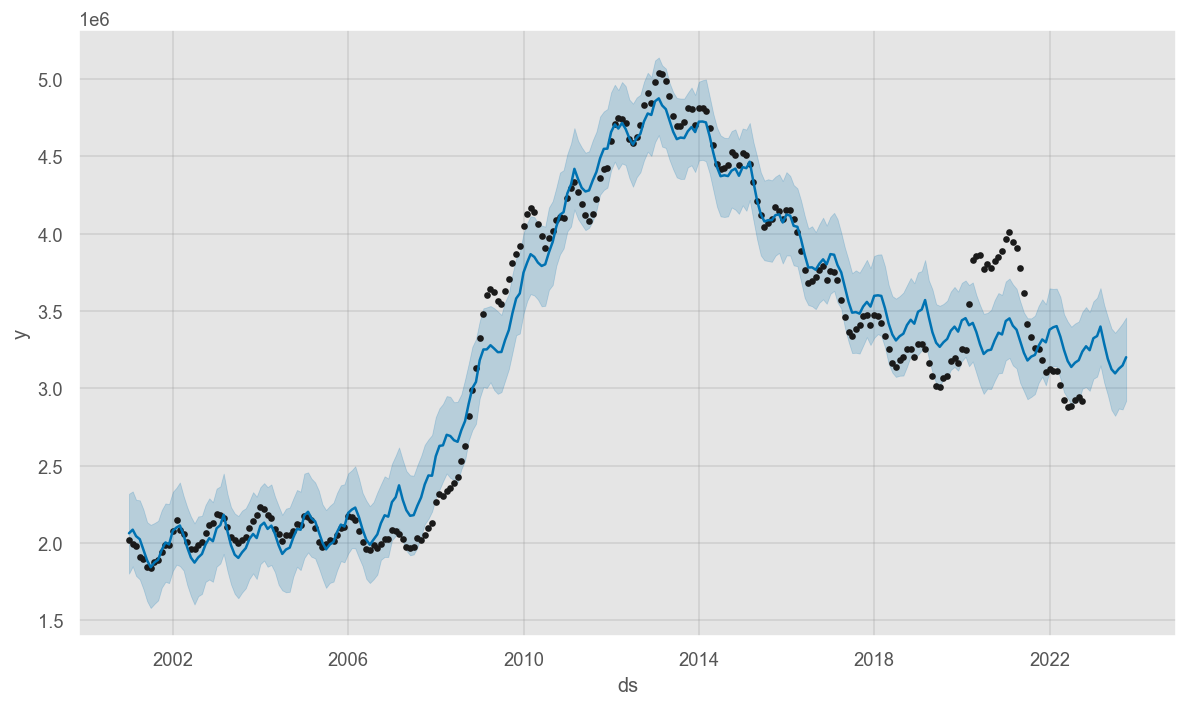

In [53]:
fig = prophet_fit.plot(future, uncertainty=True)

16:56:18 - cmdstanpy - INFO - Chain [1] start processing
16:56:18 - cmdstanpy - INFO - Chain [1] done processing


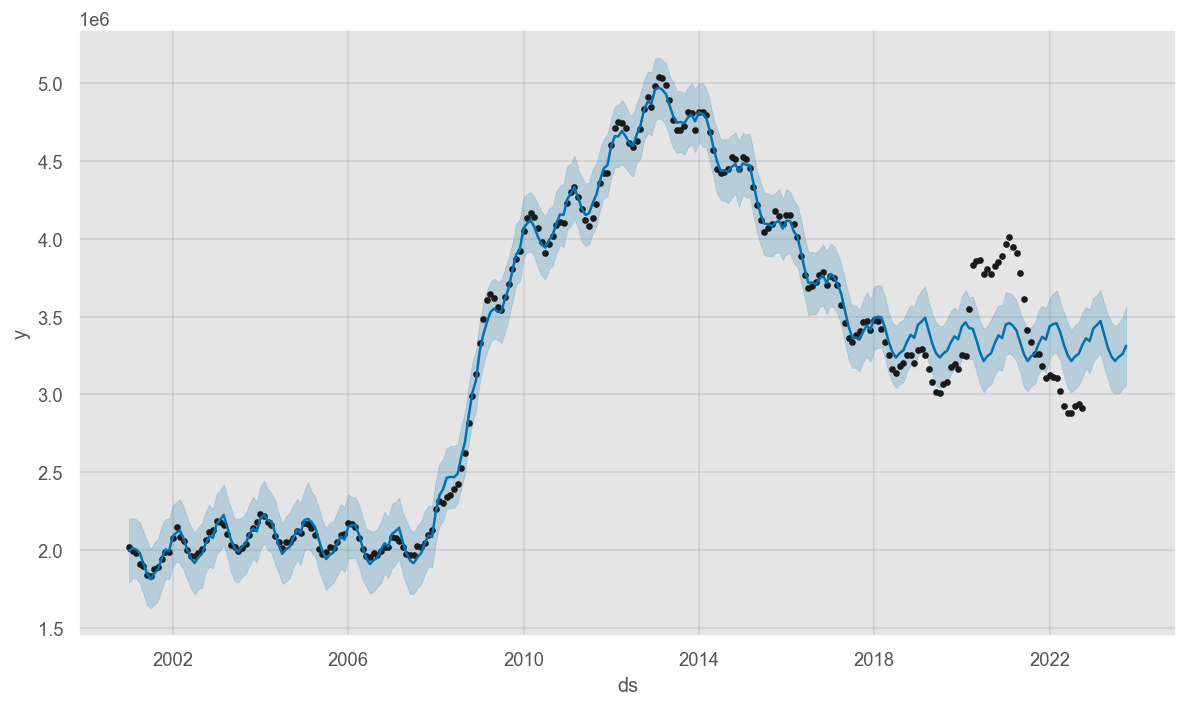

In [54]:
prophet_trend_fit = Prophet(changepoint_prior_scale=1)
future = prophet_trend_fit.fit(df).predict(future)
fig = prophet_trend_fit.plot(future)

## Caracterizando el COVID en PROPHET. PRECOVID Y POST COVID

In [55]:

lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2019-04', 'lower_window': 0, 'ds_upper': '2022-09'},
    
    

])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

holiday         ds  lower_window   ds_upper  upper_window
0  lockdown_1 2019-04-01             0 2022-09-01          1249

In [56]:
n_years=1
prophet_int2 = Prophet(holidays=lockdowns,changepoint_prior_scale=0.04)
prophet_int2 = prophet_int2.fit(df)
future2 = prophet_int2.make_future_dataframe(periods=n_years*12, freq='MS')
forecast2 = prophet_int2.predict(future2)

16:56:22 - cmdstanpy - INFO - Chain [1] start processing
16:56:30 - cmdstanpy - INFO - Chain [1] done processing


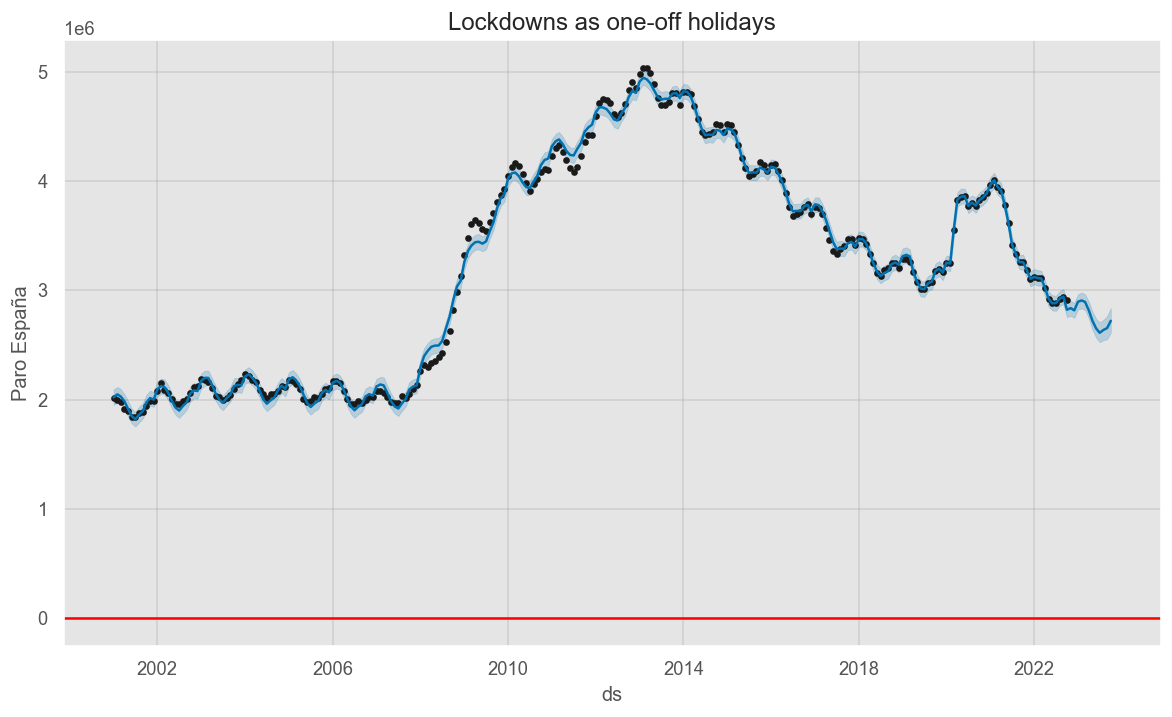

In [57]:
prophet_int2.plot(forecast2)
plt.axhline(y=0, color='red')
plt.ylabel("Paro España")
plt.title('Lockdowns as one-off holidays');

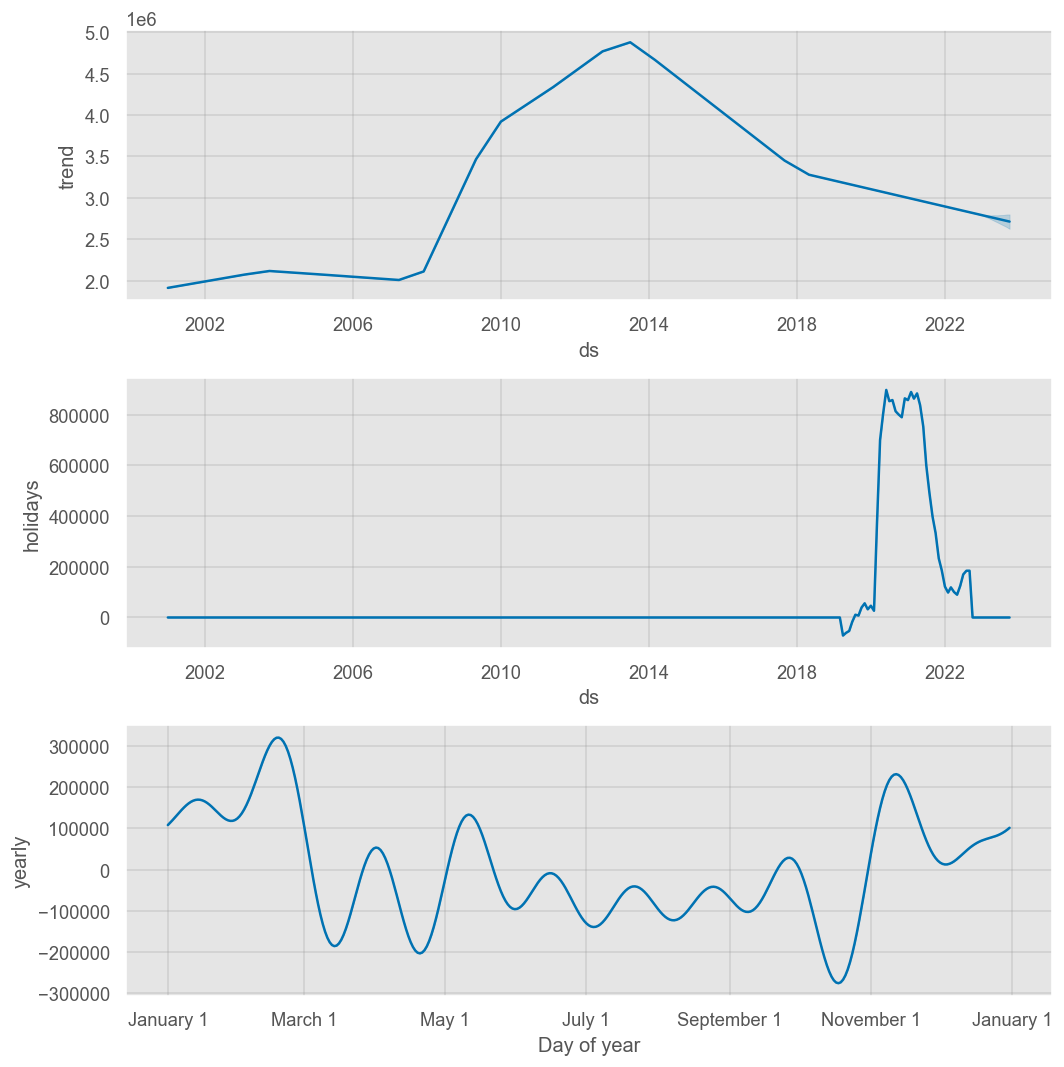

In [58]:
prophet_int2.plot_components(forecast2);

### Predicción Prophet con Covid para Noviembre 2022

In [59]:
forecast2.set_index("ds")[["yhat","yhat_lower","yhat_upper"]].loc["2022-11"]

yhat    yhat_lower    yhat_upper
ds                                                  
2022-11-01  2.836948e+06  2.767214e+06  2.902678e+06

# Comparación todos los modelos aplicados

In [62]:
compare_prophet=pd.DataFrame(columns=compare_models.columns,index=["ProphetCovid"])
compare_prophet.iloc[0,6]=forecast2.set_index("ds")[["yhat","yhat_lower","yhat_upper"]].loc["2022-11"].values[0][0]
compare_prophet.iloc[0,5]=forecast2.set_index("ds")[["yhat","yhat_lower","yhat_upper"]].loc["2022-11"].values[0][1]
compare_prophet.iloc[0,7]=forecast2.set_index("ds")[["yhat","yhat_lower","yhat_upper"]].loc["2022-11"].values[0][2]
df.set_index("ds",inplace=True)
compare_prophet.iloc[0,0]=np.sqrt(mean_squared_error(df,forecast2b.loc[:df.index[-1]].yhat))
compare_prophet.iloc[0,1]=mean_squared_error(df,forecast2b.loc[:df.index[-1]].yhat)
compare_prophet.iloc[0,2]=mean_absolute_error(df,forecast2b.loc[:df.index[-1]].yhat)
compare_prophet.iloc[0,3]=r2_score(df,forecast2b.loc[:df.index[-1]].yhat)

KeyError: "None of ['ds'] are in the columns"

In [64]:
compare_models=pd.concat([compare_prophet,compare_models])
compare_models

RMSE                MSE           MAE        R2  \
ProphetCovid           NaN                NaN           NaN       NaN   
ProphetCovid           NaN                NaN           NaN       NaN   
ProphetCovid           NaN                NaN           NaN       NaN   
sarimaEXOGEN  39406.959868  1552908486.030473  27079.562636  0.998262   
sarima_fit    42032.226735  1766708084.337431  28101.680614  0.998023   

                     AIC lower_yhat2022-11     yhat2022-11 upper_yhat2022-11  
ProphetCovid         NaN    2767214.480351    2836947.6503    2902677.830619  
ProphetCovid         NaN    2767214.480351    2836947.6503    2902677.830619  
ProphetCovid         NaN    2767214.480351    2836947.6503    2902677.830619  
sarimaEXOGEN -280.804424    2798051.349641  2863395.488616    2930015.488546  
sarima_fit    -252.37713    2798518.237626  2868535.273346    2940016.540433